# Conditional quantum wasserstein generative adversarial network for learning DIS stock prices

Generative adversarial networks (GANs) are notoriously hard to train. Since GANs don't converge—instead reaching an equilibrium—it is hard to gauge when one should stop training. However, there are several challenges towards reaching an equilibrium, the most prominent of which: diminished gradients, non-convergence, and mode collapse. In a paper by Arjovsky et al. in 2017 [[1]](https://arxiv.org/abs/1701.07875), they propose the Wasserstein generative adversarial network (WGAN), using the Wasserstein metric or Earth-Mover's distance, which mitigates several of these problems in training GANs. Here, I take inspiration from the classical WGAN to implement a hybrid quantum-classical wasserstein generative adversarial network conditioned by DIS stock prices. To be transparent, the application of a CQWGAN to stock price prediction is not well motivated but the intention here is not to complete such an intractable machine learning task, but to evaluate and explore the learnability of a CQWGAN given the vanishing gradient problem we came across in the QGAN implementation. With that said, I provide a brief outline of classical WGANs and this specific model implementation below.

## Wasserstein Generative Adversarial Networks

### Wasserstein Loss
Wasserstein GANs improve training by adopting a smooth metric for measuring the distance between two probability distributions. We will briefly overview this metric and why it has smooth gradients. As encountered in the QGAN implementation, the discriminator rapidly learns to differentiate between fake and real data samples. Although this may seem beneficial at first, in reality it overpowers the generator causing near-zero gradients for the generator to train off of. Without a rich gradient, the generator is faced to optimize without enough information/feedback on its prior generated data samples. Fortunately, the Wasserstein loss is mathematically proven to have a much broader support (subset of the domain containing non zero values) and therefore avoids vanishing gradients even when the discriminator is trained to optimality.  

For those seeking a deeper intuition behind why the Wasserstein distance works, I explain it here. The traditional loss functions that generative models are trained on depend on the Kullback Leibler divergence or the Jensen Shannon divergence, which I need not mathematically define but know that they both quantify the distance between two probability distributions. This is a crucial aspect of GAN loss functions since the ability for the discriminator to discern between fake and real data centrally depends on the discriminator's ability to learn the distance between the respective data distributions.

Unfortunately with KL and JS divergence, they both have near zero gradients as the generated distribution, $p_g$, ventures further from the real distribution, $p_r$. In addition, at the start of a GAN training procedure—when $p_g$ is highly inaccurate—the discriminator $D$ rapidly learns to differentiate between $p_g$ and $p_r$. Therefore, the loss function approaches zero and we end up with no gradient to update the loss during learning iterations.

With these problems in mind, we can address Earth Mover's distance and how it can be of help. Wasserstein distance, as also called Earth Mover’s distance (short for EM distance) can be informally interpreted as the minimum energy needed to move and transform a pile of dirt in the shape of one probability distribution to the shape of the other distribution. The cost is quantified by the sum of the amount of dirt moved multiplied by the respective moving distance for each vertical. Below is a depiction of this idea in the case of two discrete distributions ([source](https://arxiv.org/pdf/1904.08994.pdf))

<img src="./images/em_distance_plot.png" alt="Step-by-step plan of moving dirt between piles in P and Q to make them match." align="right" style="padding-left: 20px; padding_bottom: 20px">

In spirit of this idea, we will generalize to find a formula for EM distance including continuous distributions. To start, let an individual transport plan, $\gamma(x,y)$ be the percentage of dirt at point $x$ that needs to be transported such that $x$ follows the same probability distribution as $y$.

Taking $x$ as the starting point and $y$ as the ending point, we know that the amount of mass needed to complete the individual transformation is $\gamma (x, y)$ and that the distance covered is $||x - y||$. Hence, the cost for a given transformation $(x \rightarrow y)$ is $\gamma(x, y) \cdot ||x-y||$ Now to calculate the cost of a certain transport plan from $p_g$ to $p_r$, we just need to sum over the constituent costs of each individual transformation,
$$\underset{x, y}{\sum} \gamma (x, y) \cdot ||x - y|| = \underset{x,y∼\gamma}{\mathop{\mathbb{E}}} ||x - y||$$

After trying all such transport plans from $p_g$ to $p_r$, we conclude at the transport plan with the lowest cost. The cost of this most efficient transport plan is what we define as EM distance. Mathematically, we take the *infimum* (greatest lower bound), or put simply, the smallest cost in a set of all costs associated with each possible transport plan.

$$W(p_r, p_g) = \underset{\gamma∼\Pi  (p_r,p_g)}{\text{inf}} \mathop{\mathbb{E}}_{(x,y)∼\gamma}[||x − y||]$$

Above is the Wasserstein distance between two distributions $p_r$ and $p_g$ where $\Pi(p_r, p_g)$ defines the set of all possible dirt transport plans, $\gamma \in \Pi  (p_r,p_g)$, or joint probability distributions between $p_r$ and $p_g$.

### Applied to GANs
To remind ourselves of the motivation behind using Wasserstein loss, think of two disjoint distributions. If they're truly is zero overlap, then you can expect the KL divergence to blow up to $+\infty$ and the JS to jump to $log 2$ rendering both undifferentiable at that point. We observe that using Wasserstein distance, the loss here is $0$ and it remains smooth making for a stable learning process through gradient updates. This quality is especially useful for GANs since it ensures that the generator will be able to smoothly train in the beginning despite how badly its generated samples turn out to be.

Due to the intractability of evaluating all possible joint distributions in $\Pi(p_r, p_g)$, the authors in the [original WGAN paper](https://arxiv.org/abs/1701.07875) introduced a reforumalation of the orginial Wasserstein distance based on the Kantorovich-Rubinstein duality:

$$W(p_r, p_g) = \frac{1}{K} \underset{ ||f||_L \leq K}{\text{sup}} \space \mathop{\mathbb{E}}_{x∼p_r} [f(x)] - \mathop{\mathbb{E}}_{x∼p_g} [f(x)]$$

where *supremum* measures the least upper bound, or put simply, the maximum value. The derivation is out of the scope of this notebook but if you're interested in peering further I recommend reading through this [post](https://vincentherrmann.github.io/blog/wasserstein/). It's important to note that the new real-valued function $f$ must satisfy the condition $||f||_L \leq K$ meaning that the function must be $K$-Lipschitz continuous.

A real valued function $f$ is called $K$-Lipschitz continuous if there exists a real constant $K ≥ 0$ such that, for all $x_1, x_2 \in R$

$$ |f(x_1) - f(x_2)| \leq K|x_1 - x_2|$$
   
Intuitively, the Lipschitz constant $K$ ensures that our loss function is everywhere differentiable and that it doesn't have exploding gradients. Think of it as a condition that makes sure that the loss function is smooth for the whole domain by setting an upper bound on the derivative.

If we unbound $K$ to allow $f$ to pull from a family of K-Lipschitz continuous functions, ${\{f_w\}}_{\mathcal{w}\in W}$, the discriminator's new role would be to learn $w$ and arrive at a suitable $K$-Lipschitz continuous function $f_w$ such that the loss function is configured to measure the Wasserstein distance between $p_r$ and $p_g$. Using the above information, we can formally define the loss function and optimization task as

$$ L(p_r, p_g) = W(p_r, p_g) = \underset{w\in W}{\text{max}} \space \mathop{\mathbb{E}}_{x∼p_r} [f_w(x)] - \mathop{\mathbb{E}}_{z∼p_r(z)} [f_w(g_\theta(z))]$$

Notice the absence of any logarithms. The Wasserstein GAN loss function is completely dependent on the $K$-Lipschitz continuous functions. Even more importantly, the discriminator here doesn't play the role of a direct classifier for each instance, assigning a value in $[0,1]$ to evaluate the authenticity of a presented data sample. Rather, it outputs a number. This number does not have to be less than one or greater than 0. Discriminator training just tries to make the output bigger for real instances than for fake instances. Because it can't really discriminate between real and fake, the WGAN discriminator is actually called a "critic" instead of a "discriminator". This holds importance since the critics' job is to widen the gap between the score of $p_r$ and $p_g$, and the generator's objective is to close it. Unsurprisingly, the progression of the generator in this setting correlates with generated data sample quality which wasn't a fixed condition in conventional GANs. 

The only theoretical caveat to mention is the difficulty of maintaining $K$-Lipschitz continuity of the critic's function $f_w$. To overcome this, the authors of the original paper propose a simple weight clipping technique where after each gradient update, the weights $w$ are clipped between a small window like $[-0.01, 0.01]$.

### In practice
WGANs are surprisingly simple to implement in practice, even the loss function! Since the essence of the loss function is the distance between the critics evaluation for fake and real data samples, we can implement it into our QGAN like so:

$$L_D(x) = D(G(z)) - D(x) $$
$$L_G(x) = -D(G(z))$$

The critic tries to minimize the first function. In other words, it tries to maximize the difference between its average score on real samples and its score on fake samples. The generator tries to minimize the second function. In other words, It tries to maximize the discriminator's score for its fake data samples. By looking at Brownlee's [implementation](https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/) of a WGAN, I arrived at this elegant implementation of the above loss function with class labels of 1, and -1 assigned to fake data and real data, respectively. 
```
def wasserstein_loss(y_true, y_pred):
	return mean(y_true * y_pred)
```

## General overview of QWGAN
The quantum Wasserstein generative adversarial network consists of one 19 qubit parameterized quantum generator paired with a classical CNN as a discriminator. The 19 qubit quantum generator is compiled as a Keras layer and it takes as input the past 15 days of price data sent in as conditional labels and a Gaussian noise vector of length 12. The intention of the implementation is to investigate if the vanishing gradient problem faced with our QGAN implementation is alleviated with the use of the Wasserstein loss function. Below is an image of the model graph. 

<img src="./images/qwgan_model_graph.png" alt="QWGAN model graph">

<hr>

## Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.constraints import Constraint
from tensorflow.keras.utils import plot_model

In [2]:
dataset = np.load('data/dataset.npy', allow_pickle=True)
dis_dataset = dataset[1]

In [3]:
num_latent_qubits = 4
latent_dim = 3 * num_latent_qubits
n_layers = 3
wires = range(len(dis_dataset[0][0][0]) + num_latent_qubits)
weight_shapes = {"weights": (n_layers,len(wires),3)}
dev = qml.device('default.qubit', wires=wires)

In [4]:
# clip model weights to a given hypercube
class ClipConstraint(tf.keras.constraints.Constraint):
    # set clip value when initialized
    def __init__(self, clip_value):
        self.clip_value = clip_value

    # clip model weights to hypercube
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)

    # get the config
    def get_config(self):
        return {'clip_value': self.clip_value}

In [5]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [6]:
x_train, y_train = list(), list()
x_val, y_val = list(), list()
x_test, y_test = list(), list()

for i in range(len(dis_dataset[0])):
    x_train.append(dis_dataset[0][i][0])
    y_train.append(dis_dataset[0][i][1])

for i in range(len(dis_dataset[1])):
    if i <= len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_val.append(dis_dataset[1][i][0])
        y_val.append(dis_dataset[1][i][1])
    
    if i > len(dis_dataset[1][:int(0.5 * (len(dis_dataset[1])-1))]):
        x_test.append(dis_dataset[1][i][0])
        y_test.append(dis_dataset[1][i][1])

train_labels, train_y = np.asarray(x_train), np.asarray(y_train)
val_labels, val_y = np.asarray(x_val), np.asarray(y_val)
test_labels, test_y = np.asarray(x_test), np.asarray(y_test)

train_dis_dataset = [train_labels, train_y]
val_dis_dataset = [val_labels, val_y]
test_dis_dataset = [test_labels, test_y]

## Structure of QWGAN

### Discriminator

In [7]:
def define_critic():
    # weight initialization
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    #` weight constraint
    const = ClipConstraint(0.01)
    
    gen_output = layers.Input(shape=(4,))
    gen_label = layers.Input(shape=(15,))
    merge = layers.Concatenate()([gen_output, gen_label])
    merge = tf.reshape(merge, (-1, 1, 1,19))
    
    x = Conv1D(filters=64, kernel_size=1, kernel_initializer=init, kernel_constraint=const, input_shape=(None, 19))(merge)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv1D(filters=64, kernel_size=1, kernel_initializer=init, kernel_constraint=const)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # linear activation
    x = Flatten()(x)
    Output = Dense(units=1)(x)
    
    # compile model
    model = tf.keras.Model(inputs=[gen_output, gen_label], outputs=Output)
    opt = tf.keras.optimizers.RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

In [8]:
discriminator = define_critic()

discriminator.summary()

[2021-06-21 00:55:21.896 tensorflow-2-3-cpu-p-ml-m5-4xlarge-b9b58b15c8602c22bc98125af7d7:10403 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-06-21 00:55:21.947 tensorflow-2-3-cpu-p-ml-m5-4xlarge-b9b58b15c8602c22bc98125af7d7:10403 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
concatenate (Co

### Generator

In [9]:
tf.keras.backend.set_floatx('float64')

In [10]:
@qml.qnode(dev, interface="tf")
def gen_circuit(inputs, weights):
    # Embedding past time series onto circuit (bath)
    qml.templates.AngleEmbedding(inputs[:len(dis_dataset[0][0][0])], wires, rotation='X')
    
    # Gaussian noise through U3 unitaries
    noise_params = tf.reshape(inputs[len(dis_dataset[0][0][0]):], (num_latent_qubits, 3))
    qml.broadcast(unitary=qml.U3, wires=wires[-num_latent_qubits:], pattern="single", parameters=noise_params)
    
    # Adjusting parameters of generator ansatz
    qml.templates.StronglyEntanglingLayers(weights, wires=wires)
    
    # Returning normalized percentage price predictions for next 4 days in dataset 
    return [qml.expval(qml.PauliZ(i)) for i in range(len(dis_dataset[0][1][1]))]

In [11]:
def define_generator():    
    # Convert gen_circuit to Keras layer
    b_labels = keras.layers.Input(shape=(15,))
    noise = keras.layers.Input(shape=(num_latent_qubits*3,))
    merged = layers.Concatenate()([b_labels, noise])
    qlayer = qml.qnn.KerasLayer(gen_circuit, weight_shapes, output_dim=len(dis_dataset[0][1][1]), dtype="float64", name='generator_circ')(merged)
    model = tf.keras.models.Model(inputs=[b_labels, noise], outputs=[qlayer])
    return model

### Complete QWGAN 

In [12]:
# Combined model for updating generator
def define_qgan(generator, critic):
    # set weights of critic to not trainable
    for layer in critic.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # get noise and label inputs from generator model
    gen_label, gen_noise = generator.input
    # get 4 day prediction from the generator model
    g_output = generator.output
    # connect generator output and generator label as inputs into discriminator
    d = critic([g_output, gen_label])
    # define full gan as taking in generator labels and noise to output a discriminator loss
    model = keras.models.Model(inputs=[gen_label, gen_noise], outputs=d)
    
    opt = RMSprop(lr=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

### Helper functions

In [40]:
def accuracy(real_data, fake_data):
    m = tf.keras.metrics.MeanAbsoluteError()
    m.update_state(real_data, fake_data)
    acc = 1 - m.result().numpy()
    return acc

In [13]:
def generate_real_samples(train_labels, train_y, n_samples):
    # choose random instances
    ix = np.random.randint(0, train_y.shape[0], n_samples)
    # select images and labels
    X, labels = train_y[ix], train_labels[ix]
    # generate class labels
    y = -np.ones((n_samples, 1))
    return [X, labels], y

In [14]:
def generate_latent_points(n_samples, train_labels, latent_dim):
    n_classes = train_labels.shape[0]
    # generate points in the latent space with Gaussian structure
    noise_input = np.random.normal(size=(n_samples, latent_dim))
    # generate labels
    ix = np.random.randint(0, n_classes, n_samples)
    labels = train_labels[ix]
    
    return [noise_input, labels]

In [15]:
def generate_fake_samples(generator, n_samples, latent_dim):
    # generate points in latent space 
    noise_input, labels_input = generate_latent_points(n_samples, train_labels, latent_dim)
    # predict outputs
    y_pred = generator.predict([labels_input, noise_input])
    # create class labels
    y = np.ones((n_samples, 1))
    return [y_pred, labels_input], y

In [16]:
# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    plt.plot(d1_hist, label='crit_real')
    plt.plot(d2_hist, label='crit_fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.close()

### Training

In [36]:
# train the generator and critic
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=64, n_critic=5):
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(dataset[0]) / n_batch)
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    c1_hist, c2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_epo):
            c1_tmp, c2_tmp = list(), list()
            for _ in range(n_critic):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset[0], dataset[1], half_batch)
                # update critic model weights
                c_loss1 = c_model.train_on_batch([X_real, labels_real], y_real)
                c1_tmp.append(c_loss1)
                # generate 'fake' examples
                [X_fake, labels], y_fake = generate_fake_samples(g_model, half_batch, latent_dim)
                # update critic model weights
                c_loss2 = c_model.train_on_batch([X_fake, labels], y_fake)
                c2_tmp.append(c_loss2)     
            # store critic loss
            c1_hist.append(np.mean(c1_tmp))
            c2_hist.append(np.mean(c2_tmp))
            # prepare points in latent space as input for the generator
            [noise_input, train_labels] = generate_latent_points(n_batch, dataset[0], latent_dim)
            # create inverted labels for the fake samples
            y_gan = -np.ones((n_batch, 1))
            # update the generator via the critic's error
            g_loss = gan_model.train_on_batch([train_labels, noise_input], y_gan)
            g_hist.append(g_loss)
            # summarize loss on this batch
            np.save('qwgan_logs/c1_hist.npy', c1_hist)
            np.save('qwgan_logs/c2_hist.npy', c2_hist)
            np.save('qwgan_logs/g_hist.npy', g_hist)
            print('>%d, c1=%.3f, c2=%.3f g=%.3f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
    # line plots of loss
    plot_history(c1_hist, c2_hist, g_hist)
    return c1_hist, c2_hist, g_hist

In [37]:
# size of the latent space
latent_dim = 4 * 3
# create the critic
critic = define_critic()

In [38]:
# create the generator
generator = define_generator()
# create the gan
qgan_model = define_qgan(generator, critic)

In [ ]:
n_batch = 2
n_epochs = 1000

# train model
c1_loss, c2_loss, g_loss = train(generator, critic, qgan_model, [train_dis_dataset[0][:n_batch], train_dis_dataset[1][:n_batch]], latent_dim, n_batch=n_batch, n_epochs=n_epochs)

>1, c1=-0.000, c2=0.001 g=-0.063
>2, c1=-0.001, c2=0.002 g=-0.101
>3, c1=-0.002, c2=0.003 g=-0.066
>4, c1=-0.003, c2=0.003 g=-0.125
>5, c1=-0.004, c2=0.004 g=-0.151
>6, c1=-0.004, c2=0.005 g=-0.061
>7, c1=-0.005, c2=0.005 g=-0.136
>8, c1=-0.005, c2=0.006 g=-0.031
>9, c1=-0.006, c2=0.006 g=-0.076
>10, c1=-0.006, c2=0.007 g=-0.141
>11, c1=-0.007, c2=0.007 g=-0.073
>12, c1=-0.007, c2=0.007 g=-0.131
>13, c1=-0.007, c2=0.008 g=-0.082
>14, c1=-0.008, c2=0.008 g=-0.059
>15, c1=-0.008, c2=0.009 g=-0.156
>16, c1=-0.009, c2=0.009 g=-0.253
>17, c1=-0.009, c2=0.009 g=-0.157
>18, c1=-0.009, c2=0.010 g=-0.043
>19, c1=-0.010, c2=0.010 g=-0.064
>20, c1=-0.010, c2=0.011 g=-0.093
>21, c1=-0.011, c2=0.011 g=-0.107
>22, c1=-0.011, c2=0.011 g=-0.157
>23, c1=-0.011, c2=0.012 g=-0.109
>24, c1=-0.012, c2=0.012 g=-0.188
>25, c1=-0.012, c2=0.013 g=-0.145
>26, c1=-0.012, c2=0.013 g=-0.056
>27, c1=-0.013, c2=0.013 g=-0.077
>28, c1=-0.013, c2=0.014 g=-0.241
>29, c1=-0.014, c2=0.014 g=-0.147
>30, c1=-0.014, c2=0.01

### Visualizing the training process

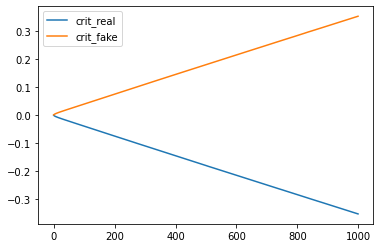

In [47]:
plt.plot(c1_loss, label='crit_real')
plt.plot(c2_loss, label='crit_fake')
plt.legend()
plt.show()

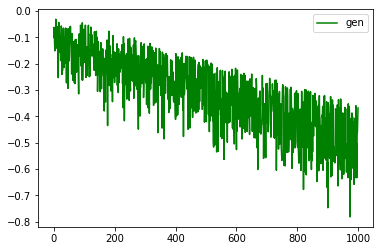

In [42]:
plt.plot(g_loss, label='gen', color='green')
plt.legend()
plt.show()

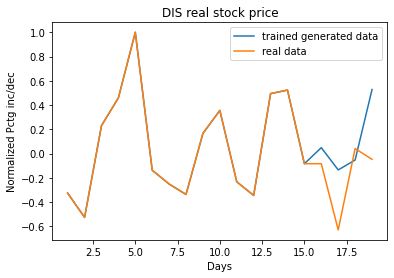

Accuracy: 0.9317530660908312


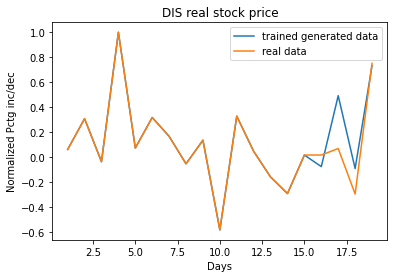

Accuracy: 0.9610850602197446


In [53]:
for i in range(n_batch):
    days =  np.arange(1, len(dis_dataset[0][0][0]) + len(dis_dataset[0][0][1]) + 1)
    real_stats = np.append(train_dis_dataset[0][i], train_dis_dataset[1][i])
    fake_stats = tf.reshape(tf.concat([np.reshape(train_dis_dataset[0][i], (1,15)), generator.predict([np.reshape(train_dis_dataset[0][i], (1,15)), np.random.normal(size=(1,12))])], 1), (19,)).numpy()

    plt.plot(days, fake_stats, label="trained generated data")
    plt.plot(days, real_stats, label="real data")
    plt.title("DIS real stock price")
    plt.xlabel("Days")
    plt.ylabel("Normalized Pctg inc/dec")
    plt.legend()
    plt.show()
    
    print(f"Accuracy: {accuracy(real_stats, fake_stats)}")

<hr>

## Conclusion

Due to limited computational resources, we only trained the CQWGAN for 1000 epochs on two data samples to evaluate the quantum generator's learnability and thus couldn't see the model through to completion. However, we observe that the quantum generator shows evidence of learning to map the latent variable space to the real distribution by the generated predictions. The diverging scores of the critic for fake and real data samples demonstrates the WGAN model at play in a quantum setting without much of a difference from the classical implementation. We conclude that the vanishing gradients we encountered with our conventional QGAN are not present in training the WGAN! 

## References

- Martin Arjovsky, Soumith Chintala, and Léon Bottou. Wasserstein gan. [arXiv:1701.07875, 2017](https://arxiv.org/abs/1701.07875).
- Mehdi Mirza, and Simon Osindero. Conditional Generative Adversarial Nets. [arXiv:1411.1784](https://arxiv.org/abs/1411.1784).
- Bobak Toussi Kiani, et al. Quantum Earth Mover's Distance: A New Approach to Learning Quantum Data. [arXiv:2101.03037](https://arxiv.org/abs/2101.03037)
- Lilian Weng. From GAN to WGAN [arXiv:1904.08994, 2019](https://arxiv.org/pdf/1904.08994.pdf).
- Brownlee. J, 2019. [How to Implement Wasserstein Loss for Generative Adversarial Networks](https://machinelearningmastery.com/how-to-implement-wasserstein-loss-for-generative-adversarial-networks/)
- Brownlee. J, 2019. [How to Develop a Wasserstein Generative Adversarial Network (WGAN) From Scratch](https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/)